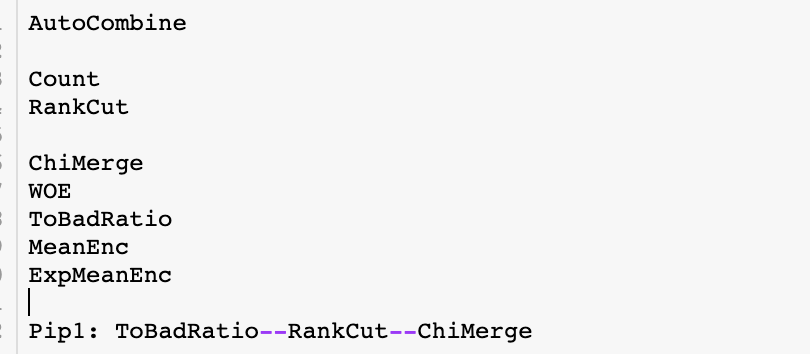

In [1]:
#  计数排名编码。它利用计数的排名对类别特征进行编码，其对线性和非线性模型都有效，而且对异常点不敏感，类别特征取值不会冲突。

#  目标编码。它基于目标变量对类别特征进行编码。对于基数（类别变量所有可能不同取值的个数）很大的离散特征，例如IP地址、网站域名、城市名、家庭地址、街道、产品编号等，上述预处理方法效果往往不太好。因为对于自然数编码方法，简单模型容易欠拟合，而复杂模型容易过拟合；对于独热编码方法，得到的特征矩阵太稀疏。对于高基数类别变量，一种有效方式则是基于目标变量对类别特征进行编码，即有监督的编码方法，其适用于分类和回归问题。例如对于分类问题，采用交叉验证的方式，即将样本划分为5 份，针对其中每一份数据，计算离散特征每个取值在另外4 份数据中每个类别的比例。为了避免过拟合，也可以采用嵌套的交叉验证划分方法。回归问题同样采用交叉验证的方式计算目标变量均值对类别变量编码。在实际问题中，我们往往利用历史数据来预测未来结果。因此我们一般基于时间信息来划分训练集和验证集，利用相同时间窗口大小的历史数据来对类别特征进行编码。例如，在广告点击率预测问题中，我们计算广告主ID在过去固定一段时间内的点击率，对广告主ID进行目标编码。目标编码方法对于基数较低的离散变量通常很有效，但对于基数特别高的离散变量，可能会有过拟合的风险。因为很多类别特征的取值样本个数太少，不具有统计意义。对于这种情况，我们通常采用贝叶斯方法，即对统计特征进行贝叶斯平滑，如拉普拉斯平滑或者先验概率和后验概率加权平均的方式。

#  类别特征之间交叉组合。除了前面提到的数值特征之间的交叉组合外，类别特征之间的交叉组合也是很重要的特征。两个类别特征进行笛卡儿积操作可以产生新的类别特征，这种操作适用于两个类别特征的基数较小的情况。两个类别特征的笛卡儿积取值个数是两个类别特征取值个数的乘积，如果两个类别特征的基数很大时，交叉后的特征基数太大，效果可能并不好。除了两个类别特征的交叉，多个类别特征也可以交叉组合，根据实际需要可以进行二阶及二阶以上的交叉组合，最后通过特征选择方法选取重要的组合方式。除了上面提到的交叉组合外，另一种特征组合方式是基于统计的组合。例如针对城市ID和商品ID两个类别特征，我们可以计算某个城市有多少不同的商品ID以及当前ID出现次数的分布，从而得到新的数值特征，或者计算某个城市出现次数最多的商品ID，从而得到一个新的类别特征。对于多个类别特征也可以进行同样的操作。例如针对年龄、性别、产品ID三个类别特征，可以计算某个年龄段不同性别的人购买过多少产品或者对当前产品ID购买次数的分布等。在实际应用中，类别特征之间的组合方式千变万化，这类特征一般从业务逻辑的角度出发进行构造。相比类别特征之间的笛卡儿积操作，基于分组统计的特征组合方式计算更加复杂，而且一般强依赖专业领域知识，因此需要对业务逻辑有较好的理解。

#  类别特征和数值特征之间交叉组合。除了数值特征之间的组合以及类别特征之间的组合之外，类别特征和数值特征之间也可以进行组合。这类特征通常是在类别特征某个类别中计算数值特征的一些统计量。例如针对用户ID，统计过去一段时间内在网站上的浏览次数、购买次数，以及购买价格的统计量，如均值、中位数、标准差、最大值和最小值等；针对产品，统计用户对产品的评分、评价次数、购买次数、浏览次数等。再比如，统计产品在某个区域的销量、产品的价格，或者当前产品的价格跟产品所在区域内的平均价格的差价等。可以看出，这类特征也强依赖专业领域知识。上面的这种组合方式也可以看作是利用数值特征对类别特征进行编码，与前面提到的基于目标变量对类别变量进行编码的方法不同的是，这里不需要划分训练集进行计算。

# 数值特征和类别特征是机器学习应用中最常见的两类特征。上面我们提到了关于这两类特征的一些常用的特征预处理技巧，基于这些技巧可以构造大量特征。但我们无法构造所有可能的特征表达形式，一方面要考虑模型的使用成本，另一方面也要考虑特征的构造成本。当然，我们可以通过特征选择选取重要的特征，但特征选择成本也很高。因此，在实际应用中我们选择性地构造特征。对于不同类别的特征采取哪一种或者哪几种方法，则依赖于我们对业务和数据本身的理解以及对模型的理解。通过对数据内部结构和规律的探索性分析，可以找到跟目标变量相关的信息，进而根据模型需要的输入形式利用预处理技术对这些信息进行编码，即构造特征。

In [1]:
import random
import pandas as pd
import numpy as np
import random
import itertools
import lightgbm as lgb
import time
from functools import reduce
from sklearn.pipeline import Pipeline
import sys
sys.path.append('../')
from auto_feat.Piplines import ToBadRatio_test, chiMerge_woe_test, RankCut_test, AutoCombine_test, EvalUtils_test
%matplotlib inline

data_path = './data/'
# test.csv  train.csv  train_target.csv
tra_x = pd.read_csv(data_path + '/train.csv')
tra_y = pd.read_csv(data_path + '/train_target.csv')
tes_x = pd.read_csv(data_path + '/test.csv')
final = tra_x.merge(tra_y,on='id')

final['certValidStop'] = final.certValidStop.astype(int)
final.fillna(-999,inplace=True)

tra_id = set(random.sample(range(final.shape[0]), 70000))
val_id = set(range(final.shape[0])) - tra_id
tra_id = [i for i in tra_id]
val_id = [i for i in val_id]
Train = final.iloc[tra_id,:].set_index(keys='id')
Valid = final.iloc[val_id,:].set_index(keys='id')
tra_x, tra_y = Train.drop('target', axis=1), Train.target
val_x, val_y = Valid.drop('target', axis=1), Valid.target

#小cate
zz = tra_x.apply(lambda x: len(x.unique())).sort_values(ascending=False)
small_cats = zz[zz<5].index.tolist()


In [ ]:
300
works=30, 2

In [8]:
workers=11
verbose=1

In [35]:
time.time()

1573646348.737608

clip since reach max_comb:230300/300
------------------------AutoCombine-fit()----------------------------
program is going to use multiprocessing with 11 Ps
processing col: comb(x_44,x_52,x_65,x_55), 0/28
processing col: comb(x_47,x_42,x_66,x_63), 0/28
processing col: comb(x_30,x_26,x_12,x_52), 0/28
processing col: comb(x_35,x_28,x_65,gender), 0/28
processing col: comb(x_49,x_28,x_14,gender), 0/28
processing col: comb(x_32,x_16,x_68,x_61), 0/28
processing col: comb(x_20,x_73,x_64,ncloseCreditCard), 0/28
processing col: comb(x_20,x_50,x_53,x_61), 0/28
processing col: comb(x_26,x_42,x_76,x_65), 0/28
processing col: comb(x_45,x_14,x_75,ncloseCreditCard), 0/28
processing col: comb(x_14,x_42,x_71,x_63), 0/20
processing col: comb(x_45,x_25,x_65,x_61), 14/28
processing col: comb(x_44,x_67,x_71,ncloseCreditCard), 14/28
processing col: comb(x_45,x_68,x_69,x_63), 14/28
processing col: comb(x_30,x_12,x_64,x_65), 14/28
processing col: comb(x_31,x_50,x_53,x_74), 14/28
processing col: comb(x_26,x_4

/home/qibo/qb_vir_env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


------------------------AutoCombine-transform()----------------------------
program is going to use multiprocessing with 11 Ps
processing col: comb(x_44,x_52,x_65,x_55), 0/28
processing col: comb(x_47,x_42,x_66,x_63), 0/28
processing col: comb(x_30,x_26,x_12,x_52), 0/28
processing col: comb(x_35,x_28,x_65,gender), 0/28
processing col: comb(x_49,x_28,x_14,gender), 0/28
processing col: comb(x_32,x_16,x_68,x_61), 0/28
processing col: comb(x_20,x_73,x_64,ncloseCreditCard), 0/28
processing col: comb(x_20,x_50,x_53,x_61), 0/28
processing col: comb(x_26,x_42,x_76,x_65), 0/28
processing col: comb(x_45,x_14,x_75,ncloseCreditCard), 0/28
processing col: comb(x_14,x_42,x_71,x_63), 0/20
processing col: comb(x_45,x_25,x_65,x_61), 14/28
processing col: comb(x_44,x_67,x_71,ncloseCreditCard), 14/28
processing col: comb(x_45,x_68,x_69,x_63), 14/28
processing col: comb(x_30,x_12,x_64,x_65), 14/28
processing col: comb(x_31,x_50,x_53,x_74), 14/28
processing col: comb(x_27,x_25,x_51,gender), 10/20
processin

../auto_feat/Piplines/EvalUtils_test.py:40: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  argmax=DfPlot.loc[(DfPlot.Bad-DfPlot.Good).argmax(),'Percent']


70.59578466415405


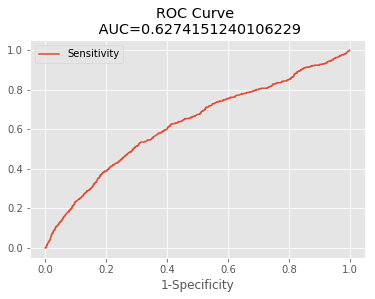

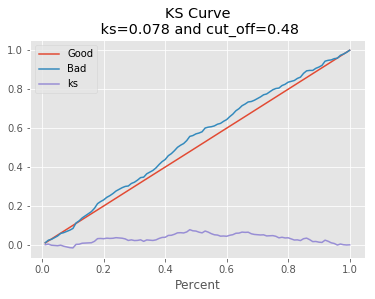

In [36]:
st = time.time()
# Pip2: 
#     小cats - AutoCombine - woe
#     小cats - AutoCombine - ExpMeanEnc - woe
from sklearn.pipeline import Pipeline
from sklearn.linear_model.logistic import LogisticRegression
pip1 = Pipeline([
                 ('auto_combine', AutoCombine_test.AutoCombine(cols=small_cats[:50], 
                                                               order=4, null_value=-999, max_comb=300,
                                                               num_process=workers, verbose=verbose)),
                 ('woe', chiMerge_woe_test.WOE_enc(cols=None, null_value=-999, iv_max=0.5, iv_min=0.05, verbose=verbose)),
                 ('clf', LogisticRegression(random_state=1))
                ])

pip1.fit(tra_x, tra_y)
# tra1 = pip1.transform(tra_x)
# val1 = pip1.transform(val_x)
pred = pip1.predict_proba(val_x)
auc, _ = EvalUtils_test.Roc_Curve(val_y, pred[:,1], True)
_, ks = EvalUtils_test.KS(val_y, pred[:,1])
print(time.time()-st)
fp=open("./logs.txt","w")
fp.write('-----------------------------time:{} -----------------------------\n'.format(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time()))))
fp.write('-----------------------------use:{} s-----------------------------\n'.format(time.time()-st))
fp.write('-----------------------------auc:{}  -----------------------------\n'.format(auc))
fp.write('-----------------------------ks:{}   -----------------------------\n'.format(ks))
for i in pip1.steps:
    step_name = i[0]
    for k,v in i[1].get_params().items():
        fp.write(k)
        fp.write(str(v))
fp.write('\n')
fp.close()

../auto_feat/Piplines/EvalUtils_test.py:40: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  argmax=DfPlot.loc[(DfPlot.Bad-DfPlot.Good).argmax(),'Percent']


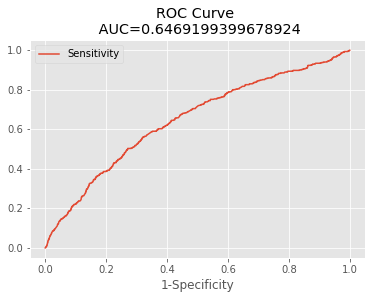

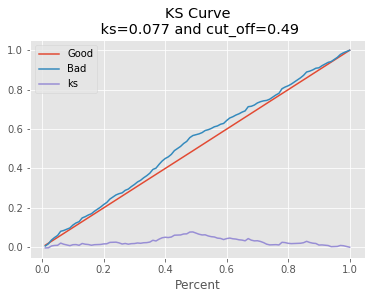

In [6]:
auc, _ = EvalUtils_test.Roc_Curve(val_y, pred[:,1], True)
_, ks = EvalUtils_test.KS(val_y, pred[:,1])
# expect = gbm.predict(tra_x)
# a = Psi(y_future=pred, y_expect=expect)

In [10]:
b[1]

0.07747061804692296

small_cats[:50]（order=2）,                auc=0.646, ks=0.077, time=161s
small_cats     （order=2）,                auc=0.665, ks=0.085, time=500s
small_cats     （order=3, max_comb=4000）, auc=0.630, ks=0.053, time=700s
small_cats     （order=3, max_comb=4000）, auc=, ks=, time=


In [5]:
# 人工部分, 可以手工做出来 连续，rank, 离散， id;
simi_cols = [('certId', 'dist', 'residentAddr'), 
             ('certValidStop', 'certValidBegin'),
            ('highestEdu', 'edu'),
            ('certId2', 'dist2', 'residentAddr2')]


#小cate
zz = tra_x.apply(lambda x: len(x.unique())).sort_values(ascending=False)
small_cats = zz[zz<5].index.tolist()

# id 类，做拆分合并 
id_vars = ['bankCard', 'dist', 'residentAddr','certId']


# rank 部分，什么都不需要
rank_vars =['age', 'setupHour', 'weekday', 'basicLevel']


# 连续部分, 需要 RankCut [类别超过20个]
cont_vars = ['certValidStop', 'certValidBegin', 'lmt',]


# 离散 部分，需要 ToBadRatio+RankCut [类别超过20个]
disc_vars = ['ethnic', 'job', 'linkRela']


In [6]:
# 针对小cats最好的办法是衍生

# cat+cat; finish
# cat+cont; to be done 
    # tra_x.groupby(small_cats[0])['lmt'].agg('mean') 然后直接map_dict

In [ ]:
import sys
sys.path.append('../')
from auto_feat.Piplines import ToBadRatio_test, chiMerge_woe_test, RankCut_test, AutoCombine_test, EvalUtils_test

# 离散部分 变成rank
disc_vars = ['ethnic', 'job', 'linkRela']
TBR = ToBadRatio_test.ToBadRatio(cols=disc_vars)
TBR.fit(tra_x, tra_y)
tra_tbr = TBR.transform(tra_x)
val_tbr = TBR.transform(val_x)

# 连续部分 变成rank
cont_vars = ['certValidStop', 'certValidBegin', 'lmt',]
RC = RankCut_test.RankCut(cols=cont_vars, bins=20, null_value=-999, return_numeric=True)
RC.fit(tra_x)
tra_rc = RC.transform(tra_x, train=True)
val_rc = RC.transform(val_x, train=False)

# rank部分
rank_vars =['age', 'setupHour', 'weekday', 'basicLevel']


#id 类，可以TBR+RC 变成rank
id_vars = ['bankCard', 'dist', 'residentAddr','certId']
TBR2 = ToBadRatio_test.ToBadRatio(cols=id_vars)
TBR2.fit(tra_x, tra_y)
tra_id_tbr = TBR2.transform(tra_x)
val_id_tbr = TBR2.transform(val_x)
RC2 = RankCut_test.RankCut(cols=tra_id_tbr.columns, bins=20, null_value=-999, return_numeric=True)
RC2.fit(tra_id_tbr)
tra_id_tbr_rc = RC2.transform(tra_id_tbr, train=True)
val_id_tbr_rc = RC2.transform(val_id_tbr, train=False)

#id 类，可以缩小类别取前6位 然后TBR+RC 变成rank
id_vars = ['bankCard', 'dist', 'residentAddr','certId']
def id_reduce(ser, null_value=-999, divide=100):
    new_ser = ser.copy()
    new_ser[new_ser!=null_value] = (new_ser[new_ser!=null_value]/divide).astype(int)
    return new_ser
tra_x['residentAddr2'] = id_reduce(tra_x.residentAddr, divide=100)
val_x['residentAddr2'] = id_reduce(val_x.residentAddr, divide=100)
tra_x['certId2'] = id_reduce(tra_x.certId, divide=100)
val_x['certId2'] = id_reduce(val_x.certId, divide=100)
tra_x['dist2'] = id_reduce(tra_x.dist, divide=100)
val_x['dist2'] = id_reduce(val_x.dist, divide=100)
tra_x['bankCard2'] = id_reduce(tra_x.bankCard, divide=1000)
val_x['bankCard2'] = id_reduce(val_x.bankCard, divide=1000)
tra_x['bankCard3'] = id_reduce(tra_x.bankCard, divide=100000)
val_x['bankCard3'] = id_reduce(val_x.bankCard, divide=100000)
new_id_vars = ['bankCard2','bankCard3', 'dist2', 'residentAddr2','certId2']
TBR3 = ToBadRatio_test.ToBadRatio(cols=new_id_vars)
TBR3.fit(tra_x, tra_y)
tra_id2_tbr = TBR3.transform(tra_x)
val_id2_tbr = TBR3.transform(val_x)
RC3 = RankCut_test.RankCut(cols=tra_id2_tbr.columns, bins=20, null_value=-999, return_numeric=True)
RC3.fit(tra_id2_tbr)
tra_id2_tbr_rc = RC3.transform(tra_id2_tbr, train=True)
val_id2_tbr_rc = RC3.transform(val_id2_tbr, train=False)

TRA = tra_id2_tbr_rc.join(tra_id_tbr_rc).join(tra_rc).join(tra_tbr).join(tra_x[rank_vars])
VAL = val_id2_tbr_rc.join(val_id_tbr_rc).join(val_rc).join(val_tbr).join(val_x[rank_vars])

CM = chiMerge_woe_test.ChiMerge(cols=TRA.columns, null_value=-999, max_groups=10)
CM.fit(TRA, tra_y)
tra_cm = CM.transform(TRA)
val_cm = CM.transform(VAL)

WOE = chiMerge_woe_test.WOE_enc(cols=tra_cm.columns)
WOE.fit(tra_cm, tra_y)
tra_woe = WOE.transform(tra_cm)
val_woe = WOE.transform(val_cm)

In [ ]:
AC = AutoCombine_test.AutoCombine(cols=tra_cm.columns, order=2, null_value=-999)
AC.fit(tra_cm)
tra_ac = AC.transform(tra_cm, True)
val_ac = AC.transform(val_cm, False)
TBR3 = ToBadRatio_test.ToBadRatio(cols=tra_ac.columns)
TBR3.fit(tra_ac, tra_y)
tra_ac_tbr = TBR3.transform(tra_ac)
val_ac_tbr = TBR3.transform(val_ac)
RC3 = RankCut_test.RankCut(cols=tra_ac_tbr.columns, bins=20, null_value=-999, return_numeric=True)
RC3.fit(tra_ac_tbr)
tra_ac_tbr_rc = RC3.transform(tra_ac_tbr, train=True)
val_ac_tbr_rc = RC3.transform(val_ac_tbr, train=False)

In [ ]:
WOE.woe_dics['CM(RC(TBR(certId)))']

In [ ]:
ME.transform(tra_x[['linkRela']])

In [ ]:
ME.fit_transform(tra_x, tra_y).linkRela

In [ ]:
tra_x['pred_temp']= (tra_x.linkRela==0)*1

In [ ]:
tra_x.groupby(by='linkRela')['pred_temp'].agg('size')

In [ ]:
z = Train[[col, 'target']].head(20)

In [ ]:
z.iloc[:6, 1]=1

In [ ]:
cumsum

In [ ]:
z

In [ ]:
z.groupby(col)['target'].cumsum()

In [ ]:
def _auc_impo(tra_x, tra_y, val_x, val_y, params=None, verbose=1):
    print(' train:{}   valid:{}'.format(tra_x.shape, val_x.shape))
    if params is None:
        params = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'binary',
              'metric': 'auc',
              'num_threads': 10,
              'num_leaves': 31,  # 31,
              'learning_rate': 0.001,  # 0.002
              'feature_fraction': 0.5,
              'lambda_l2': 100,
              'bagging_fraction': 0.5,
              'bagging_freq': 5}

    cv_train = lgb.Dataset(tra_x, tra_y.astype('int'))        
    cv_valid = lgb.Dataset(val_x, val_y.astype('int'))        
    gbm = lgb.train(params,       # 参数字典
                    cv_train,       # 训练集
                    num_boost_round=2000,       # 迭代次数
                    valid_sets=cv_train,        # 验证集
                    early_stopping_rounds = 100,
                    verbose_eval=verbose)
#     print('with best auc:{}'.format(gbm.best_score['valid_0']))
    return gbm

In [ ]:
_auc_impo(tra_x, tra_y, val_x, val_y)

In [ ]:
_auc_impo(tra_x.join(TRA, lsuffix='_'), tra_y, val_x.join(VAL, lsuffix='_'), val_y)

In [ ]:
_auc_impo(tra_ac_tbr_rc, tra_y, val_ac_tbr_rc, val_y)

In [ ]:
import pandas as pd
import numpy as np
import random
import itertools
import lightgbm as lgb
from functools import reduce
from utils import merge_box
import sys
sys.path.append('../')
from utils import _merge_box, k_order_comb
import itertools

class autofeat_draft:
    '''
    1.  k_order_comb generation 特征组合生成
    1.5. merge_box 组合特征后可以接一下merge_box
    2.  dummy_lgb_topk 特征降维
    3.  auto_transform 小微特征加减乘 生成
    '''
    def __init__(self, global_id = 'id'):
        self.global_id = global_id
    
    def k_order_comb(self, tra, val, column_names, order, merge_tail, thresh):
        assert tra.index.name == self.global_id
        return k_order_comb(tra, val, column_names, order, merge_tail, thresh)
    
    def merge_box(self, tra, val, columns, thresh):
        return merge_box(tra, val, columns, thresh)
    
    
    def dummy_lgb_topk(self, tra_x, tra_y, val_x, val_y, col_names_list, max_unique, top_k):
        # 每囤够max_unique个dummy 就跑一次 lgb top k 
        tmp_tra_df = pd.DataFrame(index = tra_x.index)
        tmp_val_df = pd.DataFrame(index = val_x.index)
        final_tra, final_val, unique_num = [], [], 0
        for idx, col in enumerate(col_names_list):
            print('dummy column: {}/{}'.format(idx, len(col_names_list)))
            unique_num += len(tra_x[col].unique())
            if unique_num <= max_unique + top_k*idx: # 因为是滚动式的，每提取出一次 dummy_lgb_topk 就在此基础上；
                tmp_tra_df = pd.get_dummies(tra_x[col], prefix=col+'_').join(tmp_tra_df)
                tmp_val_df = pd.get_dummies(val_x[col], prefix=col+'_').join(tmp_val_df)
                tmp_tra_df = tmp_tra_df[tmp_val_df.columns] # 防止 tra, val 列数因为dummy 不一致
            else:
                print('dummy reach: {}/{}, take only: {} combinations'.format(unique_num, max_unique, top_k))
                tra_1, val_1, col_names, gbm = self._auto_topk(tmp_tra_df, tra_y, tmp_val_df, val_y, top_k)
                final_tra.append(tra_1)
                final_val.append(val_1)
                unique_num = 0
                tmp_tra_df = tra_1
                tmp_val_df = val_1
                assert tmp_val_df.shape[1] == top_k
        if len(final_tra)==0:
            tra_1, val_1, col_names, gbm = self._auto_topk(tmp_tra_df, tra_y, tmp_val_df, val_y, top_k)
            final_tra.append(tra_1)
            final_val.append(val_1)
        return pd.concat(final_tra, axis=1), pd.concat(final_val, axis=1)
    
    def auto_transform(self, tra, val, column_names, order=2, op='add'):
        assert op in ['add', 'multiply', 'sub']
        assert tra.index.name == self.global_id == val.index.name
        DF_tra, DF_val = pd.DataFrame(index=tra.index), pd.DataFrame(index=val.index)
        col_names_list = [i for i in itertools.combinations(column_names, order)]
        for col_names in col_names_list:
            tra_cols = [tra[i] for i in col_names]
            val_cols = [val[i] for i in col_names]
            new_name = '{}('.format(op) + ','.join(col_names) + ')'
            if op=='add':
                DF_tra[new_name] = reduce(lambda x, y: x+y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x+y, val_cols)           
            elif op =='multiply':
                DF_tra[new_name] = reduce(lambda x, y: x*y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x*y, val_cols)
            elif op == 'sub':
                DF_tra[new_name] = reduce(lambda x, y: x-y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x-y, val_cols)
            else:
                raise Exception('op error')
        return DF_tra, DF_val

    
    def _auto_topk(self, tra_x, tra_y, val_x, val_y, top_k):
        gbm = self._auc_impo(tra_x, tra_y, val_x, val_y)
        tra_1, col_names = self._topk_feat(tra_x, gbm, top_k)
        val_1 = self._topk_feat_transfrom(val_x, col_names)
        return tra_1, val_1, col_names, gbm
    
    def _auc_impo(self, tra_x, tra_y, val_x, val_y, params=None, verbose=0):
        print(' train:{}   valid:{}'.format(tra_x.shape, val_x.shape))
        if params is None:
            params = {'task': 'train',
                  'boosting_type': 'gbdt',
                  'objective': 'binary',
                  'metric': 'auc',
                  'num_threads': 10,
                  'num_leaves': 3,  # 31,
                  'learning_rate': 0.008,  # 0.002
                  'feature_fraction': 0.5,
                  'lambda_l2': 140,
                  'bagging_fraction': 0.5,
                  'bagging_freq': 5}

        cv_train = lgb.Dataset(tra_x, tra_y.astype('int'))        
        cv_valid = lgb.Dataset(val_x, val_y.astype('int'))        
        gbm = lgb.train(params,       # 参数字典
                        cv_train,       # 训练集
                        num_boost_round=2000,       # 迭代次数
                        valid_sets=cv_valid,        # 验证集
                        early_stopping_rounds = 100,
                        verbose_eval=verbose)
        print('with best auc:{}'.format(gbm.best_score['valid_0']))
        return gbm

    def _topk_feat(self, tra_x, gbm, k, importance_type='gain'):
        assert importance_type in ['split', 'gain']
        z = pd.DataFrame()
        z['col'] = tra_x.columns
        z['imp'] = gbm.feature_importance(importance_type) 
        col_names = z.nlargest(k, 'imp').col.tolist()
        return tra_x[col_names], col_names

    def _topk_feat_transfrom(self, val_x, col_names):
        return val_x[col_names]


    
class PrePostProcess:
    '''  
    1. rank_cut 排序分箱；
    2. null 处理; 造两列空置率； 
    3. to be done: 根据分布一致性删除列；
    4. merge_box: 合箱子；
    '''   
    
    def group_simi_cols(self, tra_x, val_x, simi_cols):
        tra_all, val_all = [], []
        for i in simi_cols:
            tra_tmp, val_tmp= self.auto_transform(tra_x, val_x, column_names=list(i), order=2, op='sub')
            tra_all.append(tra_tmp)
            val_all.append(val_tmp)
        return pd.concat(tra_all, axis=1), pd.concat(val_all, axis=1)
    
    def _to_bins(self, col, q, labels=None):
        new_col, bins = pd.cut(col, bins=q, labels=labels, retbins=True)
        return new_col, bins

    def _to_bins_trans(self, col, bins, labels=None):
        new_col, bins = pd.cut(col, bins=bins, retbins=True, labels=labels)
        return new_col, bins

    def add_null_rate(self, df, null_val):
        assert 'null_num' not in df.columns
        new_df = pd.DataFrame(index=df.index)
        null_df = new_df==null_val
        new_df['null_num'] = null_df.sum(axis=1)
        new_df['null_rate'] = null_df.sum(axis=1)/null_df.shape[1]
        return new_df
    
    def rank_cut(self, tra, val, cont_vars):
        #  列 rank_cut
        tmp_tra, tmp_val = pd.DataFrame(index=tra.index), pd.DataFrame(index=val.index)
        for col_name in cont_vars:
            a1, bins1 = self._to_bins(tra[col_name], q=10, labels=range(10))
            assert col_name+'_rankcut' not in tra.columns
            tmp_tra[col_name+'_rankcut'] = a1
            b1, _ = self._to_bins_trans(val[col_name], bins=bins1, labels=range(10))
            tmp_val[col_name+'_rankcut'] = b1
        return tmp_tra, tmp_val
    

    def merge_box(self, tra, val, columns, thresh):
        return merge_box(tra, val, columns, thresh)

    def auto_transform(self, tra, val, column_names, order=2, op='add'):
        # 确认输入是否都是cat
        assert op in ['add', 'multiply', 'sub']
    #     assert tra.index.name == self.global_id == val.index.name
        DF_tra, DF_val = pd.DataFrame(index=tra.index), pd.DataFrame(index=val.index)
        col_names_list = [i for i in itertools.combinations(column_names, order)]
        for col_names in col_names_list:
            tra_cols = [tra[i] for i in col_names]
            val_cols = [val[i] for i in col_names]
            new_name = '{}('.format(op) + ','.join(col_names) + ')'
            if op=='add':
                DF_tra[new_name] = reduce(lambda x, y: x+y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x+y, val_cols)           
            elif op =='multiply':
                DF_tra[new_name] = reduce(lambda x, y: x*y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x*y, val_cols)
            elif op == 'sub':
                DF_tra[new_name] = reduce(lambda x, y: x-y, tra_cols)
                DF_val[new_name] = reduce(lambda x, y: x-y, val_cols)
            else:
                raise Exception('op error')
        return DF_tra, DF_val




In [ ]:
PPP = PrePostProcess()
FFF = autofeat_draft()

In [ ]:
a, b = FFF.k_order_comb(tra_x, val_x, column_names=tra_x.columns[:4], order=2, thresh=0.7, merge_tail=True)

In [ ]:
FFF
##### ##### ##### ##### ##### #####
    ------------------    
    auto_transform
    ------------------    
    k_order_comb
    ------------------
    dummy_lgb_topk
        _auto_topk
            _auc_impo
            _topk_feat
            _topk_feat_transfrom

        
PPP        
##### ##### ##### ##### ##### #####          
    ------------------
    group_simi_cols
        auto_transform
    ------------------
    rank_cut
        _to_bins
        _to_bins_trans


In [ ]:


import collections
import pandas as pd
import numpy as np
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import random
import math
# import featuretools as ft
import heapq
import itertools
from featexp import get_univariate_plots,get_trend_stats
warnings.filterwarnings("ignore")
# %matplotlib inline
import pickle
sys.path.append('../')
from auto_feat.AutoFeat import PrePostProcess, autofeat_draft
from auto_feat import HumanLook
# import ipdb
# from ipdb import set_trace


In [ ]:
# !python -m pip install featuretools
# !pip install featexp
# !pip install ipdb

In [ ]:
data_path = '/home/chenxiaotian/Projects/xiamen_match/data'
# test.csv  train.csv  train_target.csv
tra_x = pd.read_csv(data_path + '/train.csv')
tra_y = pd.read_csv(data_path + '/train_target.csv')
final = tra_x.merge(tra_y,on='id')
final['dist']= final.dist.apply(lambda x: int(x/100))
final['certId'] = final.certId.apply(lambda x: int(x/100))
final['residentAddr'] = final.residentAddr.apply(lambda x: int(x/100))
final['certValidStop'] = final.certValidStop.astype(int)

tra_id = set(random.sample(range(final.shape[0]), 70000))
val_id = set(range(final.shape[0])) - tra_id
tra_id = [i for i in tra_id]
val_id = [i for i in val_id]
Train = final.iloc[tra_id,:]
Valid = final.iloc[val_id,:]
tra_x, tra_y = Train.drop('target', axis=1).set_index(keys='id'), Train[['id','target']].set_index(keys='id')
val_x, val_y = Valid.drop('target', axis=1).set_index(keys='id'), Valid[['id','target']].set_index(keys='id')

tra_x['dist2']= tra_x.dist.apply(lambda x: int(x/100))
val_x['dist2']= val_x.dist.apply(lambda x: int(x/100))

tra_x['certId2']= tra_x.certId.apply(lambda x: int(x/100))
val_x['certId2']= val_x.certId.apply(lambda x: int(x/100))

tra_x['residentAddr2']= tra_x.dist.apply(lambda x: int(x/100))
val_x['residentAddr2']= val_x.dist.apply(lambda x: int(x/100))


In [ ]:
rank_cols = ['lmt', 'age'] # 大于10类的有排序含义的特征
# rank_cut 降cat

mid_cats = ['ethnic', 'job'] # 大于10类的, 小于50，无排序的特征；
# 手工 降cat + log 分箱; 可以写个自动组合箱子

big_cats = ['certId', 'certId2', 'dist', 'residentAddr', 'dist2', 'residentAddr2'] # 大于50无排序特征；
# 手工 降cat + log 分箱

time_cols = ['setupHour', 'certValidStop', 'certValidBegin', 'weekday'] 
# 手工降cat

simi_cols = [('certId', 'dist', 'residentAddr'), 
             ('certValidStop', 'certValidBegin'),
            ('highestEdu', 'edu'),
            ('certId2', 'dist2', 'residentAddr2')]

PPP = PrePostProcess()
FFF = autofeat_draft()
TRAIN_FEAT, VALID_FEAT = [], []
# rank_cut 降cat
rank_tra, rank_val = PPP.rank_cut(tra_x, val_x, rank_cols)

# 手工 降cat + log 分箱
mergebox_tra, mergebox_val = PPP.merge_box(tra_x, val_x, mid_cats+big_cats, thresh=0.92)

# simi_cols 做DIFF 变成连续型 然后分箱子
simi_tra, simi_val = PPP.group_simi_cols(tra_x, val_x, simi_cols)
rank_simi_tra, rank_simi_val = PPP.rank_cut(simi_tra, simi_val, simi_tra.columns)

# 时间分箱子
time_tra,  time_val = PPP.rank_cut(tra_x, val_x, time_cols)

TRAIN_FEAT.extend([rank_tra, mergebox_tra, simi_tra, rank_simi_tra, time_tra, tra_x])
VALID_FEAT.extend([rank_val, mergebox_val, simi_val, rank_simi_val, time_val, val_x])

aaa = pd.concat(TRAIN_FEAT, axis=1)
bbb = pd.concat(VALID_FEAT, axis=1)

In [ ]:
# FFF._auc_impo(tra_x, tra_y, val_x, val_y)

In [ ]:
# HumanLook._col_unique(aaa)[HumanLook._col_unique(aaa)>30].index.tolist()

In [ ]:
# # 核心是什么？
#     # 是涨缩
#     - 涨： auto_combine & auto_transform  评估一下
#     - 缩： merge_box & dummy_lgb_topk 评估一下

In [ ]:
ALL_Features = dict()
ALL_Features['train'] = dict()
ALL_Features['valid'] = dict()

tra_x, tra_y, val_x, val_y, aff_cls, add_merge_box = aaa, tra_y, bbb, val_y, FFF, False
ALL_Features['train']['origin']= tra_x
ALL_Features['valid']['origin']= val_x

for order in range(2,5):
    print('--------------------------order:{}--------------------'.format(order))
    cols = random.sample(tra_x.columns.tolist(), tra_x.shape[1])
    tra_x, val_x = aff_cls.k_order_comb(tra_x, val_x, column_names=cols, order=order)

    if add_merge_box:
        tra_x, val_x =  aff_cls.merge_box(tra_x, val_x, columns=tra_x.columns, thresh=0.92)
        print('eval with only lgb_top_k feats after k_order_comb & dummy lgb & merge_box with order={}'.format(order))
        _ = aff_cls._auc_impo(tra_x.values, tra_y, val_x.values, val_y)


    cols = tra_x.columns.tolist()
    tra_x_lgbk, val_x_lgbk = aff_cls.dummy_lgb_topk(tra_x, tra_y, val_x, val_y, 
                                  col_names_list=cols, max_unique=20000, top_k=300)

    print('| dummy_lgb_topk | k_order_comb | add_merge_box={}'.format(add_merge_box))
    _ = aff_cls._auc_impo(tra_x_lgbk.values, tra_y, val_x_lgbk.values, val_y)


   # 5. feature_dfs. append(new_cats)
    ALL_Features['train']['order_{}'.format(order)]= tra_x
    ALL_Features['valid']['order_{}'.format(order)]= val_x       
    with open('./feats_dict_order{}.pkl'.format(order), 'wb') as f:
        pickle.dump(ALL_Features, f, pickle.HIGHEST_PROTOCOL)


In [ ]:
 with open('./feats_dict_order4.pkl', 'rb') as f:
        z = pickle.load(f)

In [ ]:
z['train']['origin']

In [ ]:
class PipLine(PrePostProcess):
    def __init__(self):
        self.ALL_Features = dict()
        self.ALL_Features['train'] = dict()
        self.ALL_Features['valid'] = dict()
        
    def main(self, tra_x, tra_y, val_x, val_y, aff_cls, add_merge_box=False):
        '''
        cont_vars_list: a list of continues varible names;
        '''
        # 0. feature_dfs = [ori]
        self.ALL_Features['train']['origin']= tra_x
        self.ALL_Features['valid']['origin']= val_x
        
        for order in range(2,3):
            print('--------------------------order:{}--------------------'.format(order))
            cols = random.sample(tra_x.columns.tolist(), 8)
            tra_x, val_x = aff_cls.k_order_comb(tra_x, val_x, column_names=cols, order=order)
            
            if add_merge_box:
                tra_x, val_x =  aff_cls.merge_box(tra_x, val_x, columns=tra_x.columns, thresh=0.92)
                print('eval with only lgb_top_k feats after k_order_comb & dummy lgb & merge_box with order={}'.format(order))
                _ = aff_cls._auc_impo(tra_x.values, tra_y, val_x.values, val_y)

                            
            cols = tra_x.columns.tolist()
            tra_x_lgbk, val_x_lgbk = aff_cls.dummy_lgb_topk(tra_x, tra_y, val_x, val_y, 
                                          col_names_list=cols, max_unique=20000, top_k=100)
        
            print('| dummy_lgb_topk | k_order_comb | add_merge_box={}'.format(add_merge_box))
            _ = aff_cls._auc_impo(tra_x_lgbk.values, tra_y, val_x_lgbk.values, val_y)
            
            
            tra_x = PPP.add_null_rate(tra_x_lgbk, null_val=-999).join(tra_x, lsuffix ='order_{}_'.format(order))
            val_x = PPP.add_null_rate(val_x_lgbk, null_val=-999).join(val_x, lsuffix ='order_{}_'.format(order))
            tra_x = PPP.add_null_rate(tra_x_lgbk, null_val=-888).join(tra_x, lsuffix ='order_{}_'.format(order))
            val_x = PPP.add_null_rate(val_x_lgbk, null_val=-888).join(val_x, lsuffix ='order_{}_'.format(order))
            print('| dummy_lgb_topk | k_order_comb | null_val | add_merge_box={}'.format(add_merge_box))
            _ = aff_cls._auc_impo(tra_x.values, tra_y, val_x.values, val_y) 
            
           # 5. feature_dfs. append(new_cats)
            self.ALL_Features['train']['order_{}'.format(order)]= tra_x
            self.ALL_Features['valid']['order_{}'.format(order)]= val_x       
           
        # 5.根据分布一致性删除列；
        return self.ALL_Features

In [ ]:
# pipline = PipLine()
# aff = autofeat_draft(global_id='id')
# dic = pipline.main(aaa, tra_y, bbb, val_y, aff)